In [30]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def scale_image(image, scale_factor):
    return cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

def flip_image(image):
    return cv2.flip(image, 1)  # Horizontal flip

def gaussian_blur(image, k):
    return cv2.GaussianBlur(image, (k, k), 0)

def sharpen(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)


def projective_transform(image, amount):
    rows, cols = image.shape[:2]
    src_points = np.float32([[0, 0], [cols - 1, 0], [cols - 1, rows - 1], [0, rows - 1]])
    dst_points = np.float32([[0, 0], [cols - 1, 0], [cols - 1 - amount, rows - 1], [0 + amount, rows - 1]])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    return cv2.warpPerspective(image, M, (cols, rows))

def reduce_colour_depth(image, bits=4):
    # Scale down the pixel values to the desired bit depth
    factor = 2 ** (8 - bits)
    reduced_image = (image // factor) * factor
    return reduced_image

def colour_quantisation(image, k=20):
    # Convert the image to a 2D array of pixels
    pixels = np.float32(image.reshape(-1, 3))

    # Define criteria for K-Means (stop after 10 iterations or when accuracy reaches 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Apply K-Means clustering
    _, labels, palette = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    quantized = np.uint8(palette)[labels.flatten()]

    # Reshape the image back to the original dimensions
    quantized = quantized.reshape(image.shape)
    
    return quantized

def reduce_contrast(image, amount):
    return cv2.convertScaleAbs(image, alpha=1, beta=amount)

def translate_and_crop_image(image, x, y):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, x], [0, 1, y]])
    translated = cv2.warpAffine(image, M, (cols, rows))
    
    # Crop the image to remove black areas
    x_crop = int(abs(x))
    y_crop = int(abs(y))
    cropped = translated[y_crop:rows-y_crop, x_crop:cols-x_crop]
    
    # Resize back to original dimensions
    return cv2.resize(cropped, (cols, rows), interpolation=cv2.INTER_LINEAR)

def perspective_transform(image, scale):
    rows, cols = image.shape[:2]
    src_points = np.float32([[0, 0], [cols - 1, 0], [cols - 1, rows - 1], [0, rows - 1]])
    dst_points = np.float32([[0 + scale, 0 + scale], 
                             [cols - 1 - scale, 0 + scale], 
                             [cols - 1 - scale, rows - 1 - scale], 
                             [0 + scale, rows - 1 - scale]])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    return cv2.warpPerspective(image, M, (cols, rows))

def apply_random_augmentation(image):
    # Random scaling (0.9 to 1.1)
    scale_factor = random.uniform(0.9, 1.1)
    image = scale_image(image, scale_factor)
    
    # Random flipping (50% chance)
    if random.random() > 0.5:
        image = flip_image(image)
    
    # Random translation (-5% to 5% of image dimensions)
    rows, cols = image.shape[:2]
    tx = random.uniform(-0.05, 0.05) * cols
    ty = random.uniform(-0.05, 0.05) * rows
    image = translate_and_crop_image(image, tx, ty)
    
    # Random perspective transform (0 to 3% of image dimensions)
    perspective_scale = random.uniform(0, 0.03) * min(rows, cols)
    image = perspective_transform(image, perspective_scale)

    # if random.random() > 0.8:
    # image = gaussian_blur(image, 7)

    # if random.random() < 0.2:
    # image = sharpen(image)

    # image = projective_transform(image, 40)

    # image = reduce_contrast(image, 90)

    image = colour_quantisation(image, k=20)
    
    return image

def generate_and_display_augmented_images(image, num_images=3, figsize=(50, 10)):
    augmented_images = [image] + [apply_random_augmentation(image.copy()) for _ in range(num_images)]
    
    fig, axes = plt.subplots(1, num_images + 1, figsize=figsize)
    fig.suptitle("Original and Augmented Images", fontsize=16)
    
    for i, img in enumerate(augmented_images):
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title("Original" if i == 0 else f"Augmented {i}")
    
    plt.tight_layout()
    plt.show()

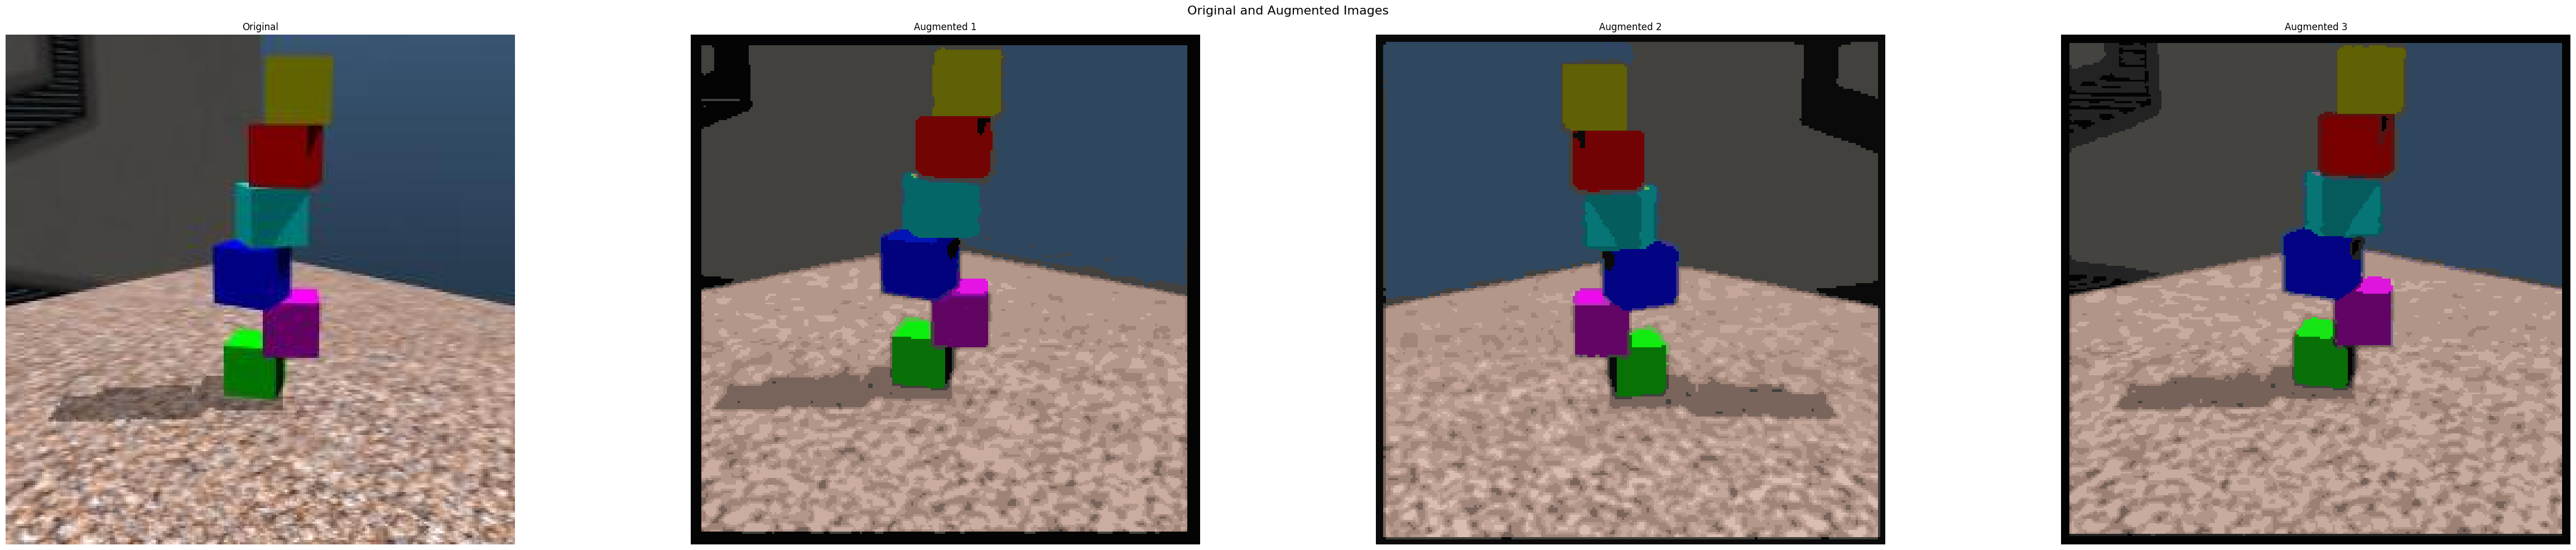

In [34]:
dir = './COMP90086_2024_Project_train/train'
img = cv2.imread(dir + "/2670.jpg")

generate_and_display_augmented_images(img, 3)